#### Improving M000 (log loss: 0.320) by changing MultinomialNB hyperparameters / vectorization

In [180]:
import sys
sys.path.append('..')

from __future__ import division, print_function 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import binarize 
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict 
%matplotlib inline
%load_ext autoreload
%autoreload 2

from evaluation import cross_validate_multilabel, multilabel_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define classes and load test/train data, some input text is "N/A" so turn na_filter off to prevent this being converted to NaN

In [181]:
toxic_classes = [
    'toxic', 'severe_toxic', 'obscene', 
    'threat', 'insult', 'identity_hate' 
]

df = pd.read_csv('../data/train.csv', na_filter=False)
X_text = df['comment_text'].values
Y = df[toxic_classes].values
ids = df['id']

### [1] Feature reduction
To improve our model accuracy we will first try reducing the number of features.

Each feature is a single token (word) found within the training data, the feature value is the count of that token within the  document record, i.e. how many times a word appeared in a particular comment

The majority of these words will not be useful in making predictions, and whilst these non-discriminative features should affect each class equally, their inclusion can still result in negative performance.

#### [1a] Drop low frequency tokens
First we will remove words that only appear in a small number of documents, as their class conditional probabilities will be less reliable.

Plotting histogram showing the token frequency distribution (x-axis: number of documents that token appears in, y-axis: number of tokens with given document frequency)

In [3]:
X = CountVectorizer(binary=True).fit_transform(X_text) # binarize features for easy histogram

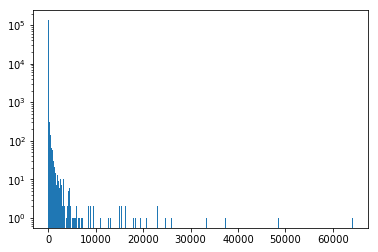

In [4]:
document_frequency = np.asarray(X.sum(axis=0)).flatten()
plt.hist(document_frequency, bins=1000)
plt.yscale('log') 
plt.show()

It is quite clear that the mast majority of features only appear in a small number of documents (~1) so we will model performance when setting a minimum document frequency (expressed as an integer document count). 

In [72]:
results = []
min_dfs = [1, 10, 100, 1000, 5000, 10000, 20000, 30000, 40000, 50000, 60000]

for min_df in min_dfs:
    cvec = CountVectorizer(min_df=min_df)
    X = cvec.fit_transform(X_text)
    cv_scores = cross_validate_multilabel(MultinomialNB(), X, Y, cv=10, scoring='neg_log_loss') 
    results.append(list(cv_scores))
    print('min_df:', min_df, '|', 'number of features:', len(cvec.vocabulary_))
    
multilabel_results(results, toxic_classes, min_dfs)

min_df: 1 | number of features: 139171
min_df: 10 | number of features: 16887
min_df: 100 | number of features: 3806
min_df: 1000 | number of features: 584
min_df: 5000 | number of features: 114
min_df: 10000 | number of features: 59
min_df: 20000 | number of features: 21
min_df: 30000 | number of features: 12
min_df: 40000 | number of features: 7
min_df: 50000 | number of features: 2
min_df: 60000 | number of features: 1


,toxic,severe_toxic,obscene,threat,insult,identity_hate,all
1,-0.531283,-0.183396,-0.419440,-0.118345,-0.450686,-0.222666,-0.320969
10,-0.354726,-0.174885,-0.280497,-0.099457,-0.302653,-0.186829,-0.233174
100,-0.347482,-0.165190,-0.256993,-0.100824,-0.284395,-0.180571,-0.222576
1000,-0.384808,-0.115726,-0.266404,-0.094421,-0.269721,-0.171468,-0.217091
5000,-0.398170,-0.095440,-0.315994,-0.063098,-0.278725,-0.114721,-0.211024
10000,-0.397452,-0.092945,-0.308322,-0.063111,-0.268064,-0.105127,-0.205837
20000,-0.389652,-0.084509,-0.286901,-0.069324,-0.253020,-0.085160,-0.194761
30000,-0.364791,-0.081422,-0.260458,-0.055465,-0.234750,-0.076341,-0.178871
40000,-0.364106,-0.085165,-0.259859,-0.058536,-0.235436,-0.077088,-0.180032
50000,-0.318343,-0.057384,-0.208724,-0.024162,-0.198619,-0.049654,-0.142814


Suprisingly, our best result comes from the model which has features with a minumum document frequent of 60,000. In this model we only have one feature...

In [106]:
cvec = CountVectorizer(min_df=60000)
X = cvec.fit_transform(X_text) 
cvec.vocabulary_

{u'the': 0}

The token 'the' is unlikely to discrimate between classes, as it is so common. The most likely explanation here is that we are simply getting a "null" model which has a probability equal to the class prior: the likelihood of observing an example  in a class (class marginal probability)

In other words for models with only very frequent, in the Bayes numerator `P(x|y)P(y)` then `P(x|y)` will be `~P(x)` (essentially independant of class) and the so `P(y)` will become the dominant term.

Our single feature model goes one step further and `P(x|y)` = 1 for both classes (sum of feature / sum of all features = 1) and so we should get a constant probability for all records (equal to the class prior)

In [107]:
mnb = MultinomialNB()
mnb.fit(X, Y[:, 0])
probs = mnb.predict_proba(X)[:,1]
probs.min() == probs.max()

True

Checking the proportion of records which have each class attribute

In [113]:
Y.sum(axis=0) / Y.shape[0]

array([ 0.09636832,  0.01006771,  0.05330148,  0.00318202,  0.04971257,
        0.00849235])

So we are dealing with very imbalanced classes, and in our class specific (one vs rest) models the class prior for the negative case will always dominate. We are essentially just prediction "not toxic"" for every record and getting the best result because "not toxic" and getting a *good* result because that is the most likely class.

This model be our new baseline (log_loss: **0.141**)

#### [1b] Select "best" features

Rather than dropping features which have a low rate of occurence, we will try to select the features which will best discriminate between classes prior to fitting the model.

We use a chi2 test for independance which compares the joint probability `P(x|y)` with `P(x)` and ranks the features which have the highest different between the conditional and marginal probabilities.

For example if:
* `P('idiot')` = 0.1 and `P('idiot'|'toxic')` = 0.6
* `P('dog')` = 0.01 and `P('idiot'|'toxic')` = 0.15<br>

Then **idiot** will have a larger chi2 value.

(The actual chi2 calculation actually considers an average across all combinations of `P('idiot'|'toxic'), P('idiot'|'not_toxic'), P('not_idiot'|'toxic'), P('not_idiot'|'not_toxic')`)

In [192]:
def kbest_feature_names(class_labels, kbest_per_class, cvec):
    # finding names of top kbest features
    kbest_features = defaultdict(list) 
    for toxic_class, kbest in zip(class_labels, kbest_per_class):
        indices = kbest.get_support(indices=True)
        scores = kbest.scores_
        sorted_indices = [index for index, score in sorted(zip(indices, scores), key=lambda x: x[1])]  
        for index in sorted_indices:
            kbest_features[toxic_class].append(cvec.get_feature_names()[index])   
            
    return pd.DataFrame(kbest_features) 

In [188]:
cvec = CountVectorizer()
X = cvec.fit_transform(X_text)
kbest_per_class = [SelectKBest(chi2, k=15).fit(X, y) for y in Y.T]

Before fitting any models here are the top features per class according to chi2 value

In [189]:
kbest_feature_names(toxic_classes, kbest_per_class, cvec) 

,identity_hate,insult,obscene,severe_toxic,threat,toxic
0,centraliststupid,fat,cunt,cunt,edie,fuck
1,fat,fucking,faggot,fuck,kill,fucking
2,gay,hate,fat,fucking,lifetime,nigger
3,jew,jew,fuck,kill,murder,penis
4,licker,moron,fucking,mexicans,rvv,pig
5,mexicans,nigger,nigger,niggas,supertr0ll,shit
6,niggas,suck,penis,offfuck,the_real_stephen_hawkinghttp,suck
7,nigger,twat,shit,shit,wales,the
8,niggers,you,suck,suck,wanta,you
9,tommy2010,yourselfgo,yourselfgo,yourselfgo,youcaltlas,fat


Most of these results seem logical and are tokens you would normally associate with toxic comments, however we are getting a few spurious results likely caused by low frequency tokens so we will rerun using a small cut-off for rare tokens. 

In [190]:
cvec = CountVectorizer(min_df=10)
X = cvec.fit_transform(X_text)
kbest_per_class = [SelectKBest(chi2, k=15).fit(X, y) for y in Y.T]

In [191]:
kbest_feature_names(toxic_classes, kbest_per_class, cvec) 

,identity_hate,insult,obscene,severe_toxic,threat,toxic
0,gay,dick,cock,bitches,ass,cunt
1,die,you,you,suck,ban,you
2,suck,suck,fuck,mexicans,will,suck
3,nigger,cunt,shit,anal,420,nigger
4,cunt,hate,bullshit,fuck,pathetic,bitch
5,niggers,jew,fucking,bitch,bail,the
6,mexicans,fat,penis,cocksucker,fuckin,fat
7,jew,twat,dick,die,lifetime,shit
8,fuck,moron,ass,shit,jim,die
9,licker,nigger,cunt,kill,wales,ass


These results look more robust. Whilst we see some of the same tokens being the best feature for multiple classes, there does seem to be a general theme in most cases. For example most of the top features in "identity_hate" target ethnicity / orientation etc. 

Will now try fitting models with only k best features retained, note that chi2 will be calculated within the cross-validation folds to avoid information from the full set leaking into the model.

In [260]:
def kbest_pipeline(k, classifier):
    return Pipeline([
        ('kbest', SelectKBest(chi2, k=k)),
        ('classifier', classifier) 
    ])

In [250]:
results = []
kbest = [1,5,10,20,30,40,50,60,70,80,90,100]
cvec = CountVectorizer(min_df=10)
X = cvec.fit_transform(X_text)

for k in kbest:
    cv_scores = cross_validate_multilabel(kbest_pipeline(k, MultinomialNB()), X, Y, cv=10, scoring='neg_log_loss') 
    results.append(list(cv_scores))
    print('kbest:', k)

kbest: 1
kbest: 5
kbest: 10
kbest: 20
kbest: 30
kbest: 40
kbest: 50
kbest: 60
kbest: 70
kbest: 80
kbest: 90
kbest: 100


In [248]:
multilabel_results(results, toxic_classes, kbest) 

,toxic,severe_toxic,obscene,threat,insult,identity_hate,all
1,-0.317029,-0.056312,-0.208124,-0.021474,-0.197668,-0.048953,-0.141593
5,-0.317998,-0.055808,-0.192579,-0.022700,-0.197841,-0.050711,-0.139606
10,-0.305979,-0.059415,-0.180888,-0.023335,-0.186421,-0.051306,-0.134557
20,-0.264281,-0.062739,-0.149942,-0.025550,-0.183395,-0.055534,-0.123574
30,-0.261351,-0.068612,-0.131687,-0.033252,-0.163661,-0.058057,-0.119437
40,-0.267132,-0.070520,-0.133580,-0.035049,-0.163427,-0.069456,-0.123194
50,-0.274250,-0.071187,-0.140179,-0.039704,-0.164385,-0.079467,-0.128196
60,-0.277846,-0.072106,-0.144533,-0.047578,-0.175228,-0.087153,-0.134074
70,-0.280174,-0.073870,-0.146571,-0.051935,-0.178308,-0.093336,-0.137365
80,-0.282748,-0.075114,-0.150846,-0.056728,-0.182416,-0.098956,-0.141135


Whilst selecting top features gave us a minor improvement (k=30) the performance appears to still impacted by the class imbalance. This is most noticeable in the classes which have the smallest proportion of positive samples (e.g. identity hate) we are actually getting a worse result by adding token features to the model. 

This is because the class prior is most influential in these cases and will still achieve the best result by essentially assuming all cases are negative.

Will try re-running the last test with uniform class priors, although will likely get a worse result as we assuming the marginal `P(yi)` = `P(not_yi)` (n.b. Using larger k values as we no longer have reliable prior) 

In [253]:
results = []
kbest = [50,100,200,300,500,750,1000]
cvec = CountVectorizer(min_df=10)
X = cvec.fit_transform(X_text)

for k in kbest:
    cv_scores = cross_validate_multilabel(kbest_pipeline(k, MultinomialNB(fit_prior=False)), X, Y, cv=10, scoring='neg_log_loss') 
    results.append(list(cv_scores))
    print('kbest:', k)

kbest: 50
kbest: 100
kbest: 200
kbest: 300
kbest: 500
kbest: 750
kbest: 1000


In [254]:
multilabel_results(results, toxic_classes, kbest) 

,toxic,severe_toxic,obscene,threat,insult,identity_hate,all
50,-0.366229,-0.530969,-0.293412,-0.316796,-0.334398,-0.354402,-0.366034
100,-0.339806,-0.370090,-0.266363,-0.265583,-0.308295,-0.265856,-0.302665
200,-0.333080,-0.282233,-0.272830,-0.248829,-0.296893,-0.279281,-0.285524
300,-0.336874,-0.278493,-0.282317,-0.246813,-0.310599,-0.295175,-0.291712
500,-0.349037,-0.273103,-0.301889,-0.246370,-0.328691,-0.307564,-0.301109
750,-0.361229,-0.281610,-0.315977,-0.247860,-0.341155,-0.319008,-0.311140
1000,-0.371568,-0.286487,-0.328933,-0.250799,-0.354797,-0.324738,-0.319554


As expected results are worse, to avoid this we need to find a way of making the class prior less influential, but not ignored completely.

Will explore a different approach using a logistic regression from the a Kaggle kernel that achieved log_loss of 0.052 in notebooks d002 to see if we can identify the reason for the increased performance. 